In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('../../TMENS_analysis/')) # use the same src as TMENS_analysis
if module_path not in sys.path:
    sys.path.append(module_path)
os.getcwd()

'/scratch/anissa.el/macro_micro_niches/macro_micro_niches2022/ISS_analysis/notebooks'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import json
import qpsolvers
import warnings
import random
warnings.filterwarnings('ignore')

from matplotlib.legend import Legend
from skimage import io
from pathlib import Path
from sklearn.decomposition import PCA
from src.utils.archetypes import ArchetypalAnalysis
from src.CellAbundance import CellAbundance, generate_abundance_matrix, join_abundance_matrices
from src.utils.visualization import radius_pc_heatmap, plot_cells_positions, plot_cev_radius, plot_stacked_var_radius, radius_pc_all_variance, radius_pc_variance_contourf, plot_cells_markers_tmens
from src.utils.visualization import plot_scatter_pca, plot_3Dscatter_pca, archetypes_bar_plot, archetype_simple_plot, plot_cells_positions, plot_all_tumors_cell_positions, get_segmentation_matrix
from src.utils.equations import arch2color, alfa2rgb, scale, color_mapper
from src.utils.equations import compute_cells_niches_weights, get_niches_cell_abund
from functools import partial

## Pre-processing data: original cell types labels

In [3]:
cell_detailed_data = pd.read_csv("/scratch/ziqi.kang/HIFI_TMENs_analysis/My_cell_positions_data/ISS_dataset/Cell_type_deep_clusters/PCW13/S1T1_mALL_complex_celltypes_formatted.csv")
cell_cluster_data = pd.read_csv("/scratch/ziqi.kang/HIFI_TMENs_analysis/My_cell_positions_data/ISS_dataset/Cell_type/PCW13/S1T1_pciseq_mALL_pciseq_results_V02.csv")
cluster_name = pd.read_excel("/scratch/ziqi.kang/HIFI_TMENs_analysis/My_cell_positions_data/ISS_dataset/Annotation of clusters.xlsx")
DATA_PATH= "../data/original_celltypes/"
ROOT_DATA_PATH = "../data/original_celltypes/"

In [4]:
cell_detailed_data["cluster_info"] = cell_cluster_data["name"] # add cluster info to detailed cell type data table
cell_detailed_data["X"] = cell_detailed_data["X"]*0.325 #convert pixels to micrometers: 1 pix = 0.325 um
cell_detailed_data["Y"] = cell_detailed_data["Y"]*0.325

print(cluster_name.head())
#brief_celltype = [] # add brief cell type annotation to cell type data table
#for i in cell_detailed_data["cluster_info"]: 
#    cell_type = cluster_name.loc[cluster_name["Unnamed: 0"] == i, "NIPMAP_Annotation"].values[0]
#    brief_celltype.append(cell_type)

#cell_detailed_data["brief_celltype"] = brief_celltype
#cell_detailed_data[0:10,:]

  Unnamed: 0 ISS cell type  ST cell type      Annotation NIPMAP_Annotation  \
0       x_0_    cluster_0_             0     Mesenchymal       Mesenchymal   
1       x_1_    cluster_1_             1     Mesenchymal       Mesenchymal   
2       x_2_    cluster_2_             2     Mesenchymal       Mesenchymal   
3       x_3_    cluster_3_             3     Mesenchymal       Mesenchymal   
4       x_4_    cluster_4_             4  Prol. Mesench.       Mesenchymal   

  P.S.  
0  NaN  
1  NaN  
2  NaN  
3  NaN  
4  NaN  


In [5]:
print(len(cell_detailed_data["cell type"].unique()))
print(cell_detailed_data["cell type"].unique())
cell_detailed_data.head()


73
['Proximal secretory' 'SFTPChigh distal' 'CTGFhigh distal epithelial'
 'Proliferating smooth muscle ' 'Lymphatic endothelial'
 'Immature arterial 2' 'Proliferating mes. 2' 'Arterial'
 'Proliferating mes. 3' 'Ciliated epithelial' 'Neuronal'
 'Proliferating epithelial 2' 'Pericyte' 'Aimmature ASM 2'
 'Immature airway fibroblast 1' 'Megakaryocyte 1' 'Proximal progenitor 1'
 'SOX9high ETV5high distal epith.' 'Proliferating epithelial 1'
 'Bronchial endothelial' 'Neuroendocrine 2' 'Neuroendocrine 1'
 'NE progenitor' 'Chondroblast' 'Airway smooth muscle (ASM)'
 'Proximal progenitor 2' 'Conventional dendritic' 'Macrophage'
 'Airway fibroblast' 'Adventitial fibroblast '
 'Immature advenstitial fibroblast' 'Proliferating myeloid' 'Mesothelial'
 'Immature ASM 1' 'Immature mesenchymal 5' 'Immature mesenchymal 3'
 'Monocyte' 'Immature airway fibroblast 2' 'Proliferating endothelial 2'
 'Capillary' 'Proliferating mes. 1' 'Immature arterial 1'
 'SOX9high ETV5medium distal epith.' 'Proliferating e

,Unnamed: 0,X,Y,Immature endothelial 1,Immature endothelial 2,Proliferating endothelial 1,Immature endothelial 3,Immature arterial 1,Venous,Proliferating endothelial 2,...,VEGFB,VEGFC,VEGFD,WIF1,WNT11,WNT2,WNT2B,WNT5A,WNT7B,cluster_info
0,0,379.739597,6497.374371,2.614967e-03,0.003821,0.002474,2.203735e-03,2.675487e-03,0.003915,0.005683,...,0,0,1,0,0,0,0,0,0,x_12_
1,1,390.152654,6473.723349,1.334189e-04,0.000314,0.000266,1.452771e-04,1.490956e-04,0.000981,0.000561,...,1,0,0,0,0,0,0,2,1,x_13_
2,2,400.809890,6491.157143,2.907458e-06,0.000004,0.000002,4.334561e-06,2.084550e-06,0.000008,0.000005,...,0,0,0,0,0,1,0,0,4,x_13_
3,3,400.021080,6454.861932,1.568511e-05,0.000031,0.000025,1.760952e-05,5.884609e-05,0.000016,0.000045,...,0,0,0,2,0,0,0,0,2,x_13_
4,4,406.105910,6479.865780,5.172385e-07,0.000002,0.000003,4.384865e-07,2.287367e-07,0.000002,0.000004,...,0,0,0,1,0,0,0,3,4,x_12_


In [63]:
'''
cell_position_info = pd.DataFrame(columns=['x', 'y', 'label', 'cell_type'])
cell_position_info["x"] = cell_detailed_data["X"]
cell_position_info["y"] = cell_detailed_data["Y"]
cell_position_info["label"] = cell_detailed_data["Unnamed: 0"]
cell_position_info["cell_type"] = cell_detailed_data["cell type"]#cell_detailed_data["brief_celltype"]


#print(min(cell_position_info["x"]))
minX = min(cell_position_info["x"])
minY = min(cell_position_info["y"])
#print(min(cell_position_info["y"]))

cell_position_info.head()
'''


,x,y,label,cell_type
0,1168.429530,19991.921141,0,Proximal secretory
1,1200.469703,19919.148767,1,SFTPChigh distal
2,1233.261200,19972.791209,2,CTGFhigh distal epithelial
3,1230.834091,19861.113636,3,SFTPChigh distal
4,1249.556647,19938.048555,4,SFTPChigh distal


In [51]:
#cell_position_info.rename(columns = {'x':'x_origin', 'y':'y_origin'}, inplace = True)
#cell_position_info['x'] = cell_position_info['x_origin']-minX  #cell_position_info['x_origin']-min(cell_position_info['x_origin'])
#cell_position_info['y'] = cell_position_info['y_origin']-minY  #cell_position_info['y_origin']-min(cell_position_info['y_origin'])

#cell_position_info['x']= cell_position_info.apply(lambda x: x["x"]-minX,axis=1)
#cell_position_info['y']= cell_position_info.apply(lambda x: x["y"]-minY,axis=1)
#cell_position_info.head()
#print(min(cell_position_info['x']))
#print(min(cell_position_info['y']))

,x,y,label,cell_type
0,-79.622709,18255.130580,0,Proximal secretory
1,-47.582536,18182.358207,1,SFTPChigh distal
2,-14.791038,18236.000648,2,CTGFhigh distal epithelial
3,-17.218148,18124.323076,3,SFTPChigh distal
4,1.504409,18201.257994,4,SFTPChigh distal


In [6]:
#DATA_PATH = "/scratch/ziqi.kang/HIFI_TMENs_analysis/My_cell_positions_data/ISS_dataset/Region_size_50000/"
cell_position_info = pd.DataFrame(columns=['x', 'y', 'label', 'cell_type'])
cell_position_info["x"] = cell_detailed_data["X"]
cell_position_info["y"] = cell_detailed_data["Y"]
cell_position_info["label"] = cell_detailed_data["Unnamed: 0"]
cell_position_info["cell_type"] = cell_detailed_data["cell type"]

xmin=1500
xmax=8000
ymin=7000
ymax=13500

#DATA_PATH = Path("/scratch/ziqi.kang/HIFI_TMENs_analysis/My_cell_positions_data/ISS_dataset/Region_test_6500/")
#DATA_PATH.mkdir(parents=True, exist_ok=True)

patch = cell_position_info.loc[(cell_position_info['x'] >= xmin) & (cell_position_info['x'] <= xmax) & (cell_position_info['y'] >= ymin) & (cell_position_info['y'] <= ymax)]
patch.rename(columns = {'x':'x_origin', 'y':'y_origin'}, inplace = True)
patch['x'] = patch['x_origin']-xmin
patch['y'] = patch['y_origin']-ymin
patch.to_csv("{}/patient{}_cell_positions.csv".format(DATA_PATH,1), index=False)
#cell_position_info.to_csv("{}/patient{}_cell_positions.csv".format(DATA_PATH,1), index=False)


In [7]:
cell_position_info.sort_values(["y"],ascending=[True])
patch.sort_values(["x"],ascending=[True])

,x_origin,y_origin,label,cell_type,x,y
77662,1500.204216,8429.135562,77662,SFTPChigh distal,0.204216,1429.135562
77848,1500.224492,7987.157790,77848,Proliferating mes. 2,0.224492,987.157790
77923,1500.471622,8764.426351,77923,Proliferating mes. 2,0.471622,1764.426351
77877,1500.487614,12963.391680,77877,Proliferating mes. 2,0.487614,5963.391680
77776,1500.488269,9582.118913,77776,Aimmature ASM 2,0.488269,2582.118913
...,...,...,...,...,...,...
175565,7999.741136,12434.226407,175565,Proliferating epithelial 2,6499.741136,5434.226407
175576,7999.830890,8893.257971,175576,Proliferating smooth muscle,6499.830890,1893.257971
175604,7999.878533,9739.755114,175604,Immature advenstitial fibroblast,6499.878533,2739.755114
175638,7999.978357,9401.798675,175638,Proliferating endothelial 3,6499.978357,2401.798675


KeyError: 'Proliferating smooth muscle '

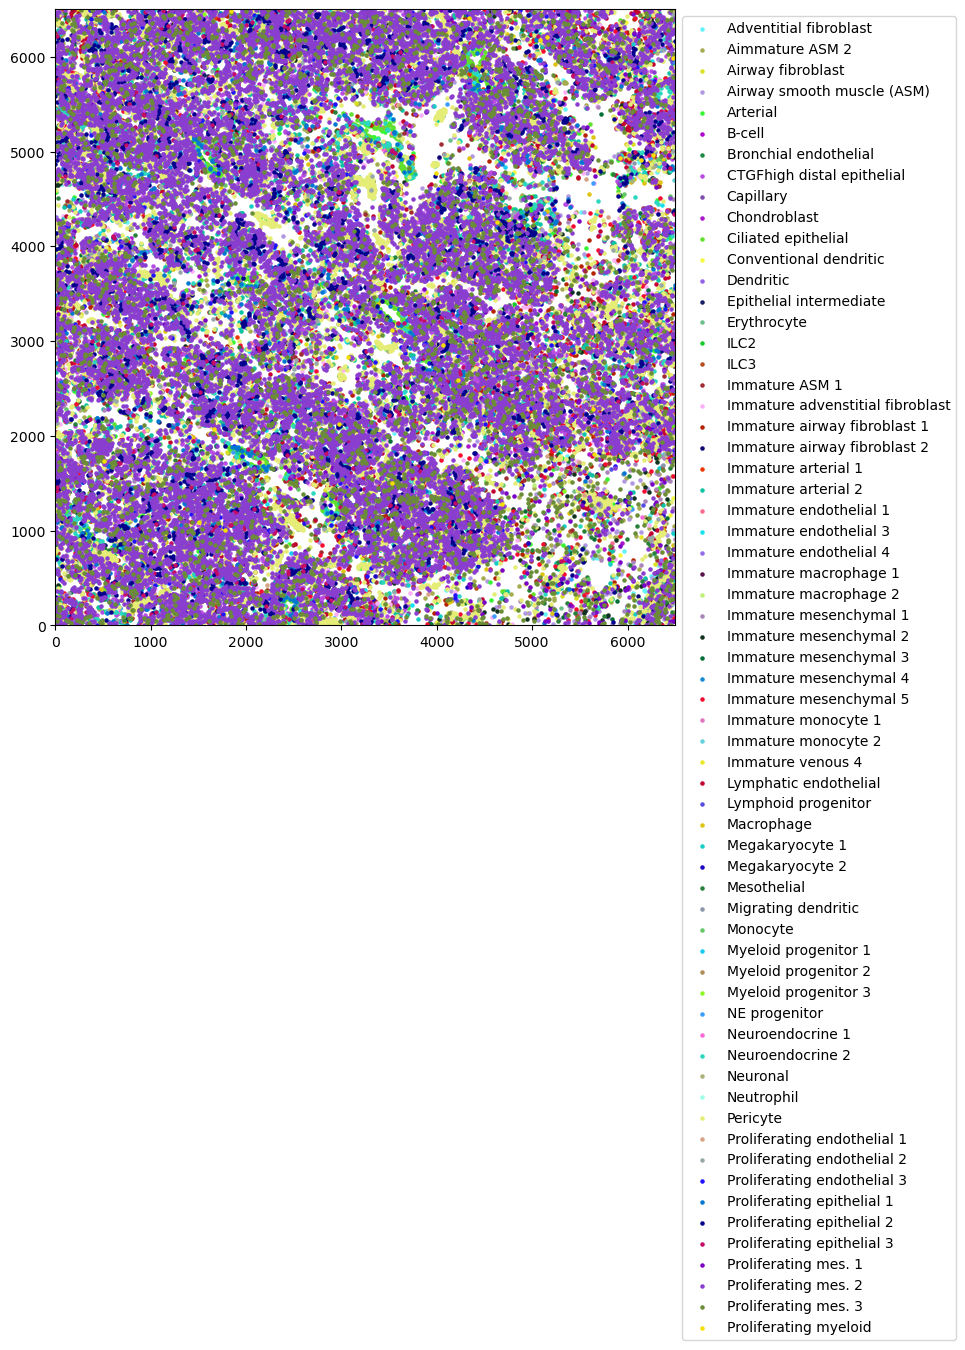

In [8]:
CELL_TYPES = ["Proximal secretory","SFTPChigh distal","CTGFhigh distal epithelial","Proliferating smooth muscle",
"Lymphatic endothelial","Immature arterial 2","Proliferating mes. 2","Arterial","Proliferating mes. 3",
"Ciliated epithelial","Neuronal","Proliferating epithelial 2","Pericyte","Aimmature ASM 2",
"Immature airway fibroblast 1","Megakaryocyte 1","Proximal progenitor 1","SOX9high ETV5high distal epith.",
"Proliferating epithelial 1","Bronchial endothelial","Neuroendocrine 2","Neuroendocrine 1",
"NE progenitor","Chondroblast","Airway smooth muscle (ASM)","Proximal progenitor 2","Conventional dendritic",
"Macrophage","Airway fibroblast","Adventitial fibroblast ","Immature advenstitial fibroblast",
"Proliferating myeloid","Mesothelial","Immature ASM 1","Immature mesenchymal 5","Immature mesenchymal 3",
"Monocyte","Immature airway fibroblast 2","Proliferating endothelial 2","Capillary","Proliferating mes. 1",
"Immature arterial 1","SOX9high ETV5medium distal epith.","Proliferating endothelial 3","Proliferating epithelial 3",
"Immature mesenchymal 1 ","ILC3","Epithelial intermediate","Immature endothelial 4","B-cell","Erythrocyte",
"Immature mesenchymal 2","Immature endothelial 3","Megakaryocyte 2","Myeloid progenitor 3","Migrating dendritic",
"mast/basophil","Immature endothelial 1","Venous ","Dendritic","Immature monocyte 2","Neutrophil",
"Proliferating endothelial 1","ILC2","Immature venous 4","Myeloid progenitor 1","Immature macrophage 2",
"Myeloid progenitor 2","Immature mesenchymal 4","Lymphoid progenitor","Immature monocyte 1","Natural killer (NK)",
"Immature macrophage 1"]
plot_cells_positions(patch, CELL_TYPES, segment_image=False, segmentation_type='hard',
                     color_vector=None,counting_type='abs', h=6500, w=6500, granularity=25, radius=25,
                     pca_obj=None, AA_obj=None, to_plot='all',path_fig=None)

## Radius analysis: sampling site size selection

In [9]:

#CELL_TYPES = ['secretory', 'epithelial', 'proliferating smooth muscle', 'lymphatic endothelial', 'arterial', 
#'mesenchymal', 'ciliated epithelial', 'neuronal', 'pericyte', 'ASM', 
#'fibroblast', 'megakaryocyte', 'proximal progenitor', 'endothelial', 'neuroendocrine', 
#'chondroblast', 'Dendritic', 'macrophage', 'myeloid', 
#'mesothelial', 'monocyte', 'capillary', 'ILC3', 'B-cell', 
#'erythrocyte', 'myeloid progenitor', 'mast/basophil', 'venous', 
#'neutrophil', 'ILC2', 'lymphoid progenitor', 'natural killer']

CELL_TYPES = ["Proximal secretory","SFTPChigh distal","CTGFhigh distal epithelial","Proliferating smooth muscle",
"Lymphatic endothelial","Immature arterial 2","Proliferating mes. 2","Arterial","Proliferating mes. 3",
"Ciliated epithelial","Neuronal","Proliferating epithelial 2","Pericyte","Aimmature ASM 2",
"Immature airway fibroblast 1","Megakaryocyte 1","Proximal progenitor 1","SOX9high ETV5high distal epith.",
"Proliferating epithelial 1","Bronchial endothelial","Neuroendocrine 2","Neuroendocrine 1",
"NE progenitor","Chondroblast","Airway smooth muscle (ASM)","Proximal progenitor 2","Conventional dendritic",
"Macrophage","Airway fibroblast","Adventitial fibroblast ","Immature advenstitial fibroblast",
"Proliferating myeloid","Mesothelial","Immature ASM 1","Immature mesenchymal 5","Immature mesenchymal 3",
"Monocyte","Immature airway fibroblast 2","Proliferating endothelial 2","Capillary","Proliferating mes. 1",
"Immature arterial 1","SOX9high ETV5medium distal epith.","Proliferating endothelial 3","Proliferating epithelial 3",
"Immature mesenchymal 1 ","ILC3","Epithelial intermediate","Immature endothelial 4","B-cell","Erythrocyte",
"Immature mesenchymal 2","Immature endothelial 3","Megakaryocyte 2","Myeloid progenitor 3","Migrating dendritic",
"mast/basophil","Immature endothelial 1","Venous ","Dendritic","Immature monocyte 2","Neutrophil",
"Proliferating endothelial 1","ILC2","Immature venous 4","Myeloid progenitor 1","Immature macrophage 2",
"Myeloid progenitor 2","Immature mesenchymal 4","Lymphoid progenitor","Immature monocyte 1","Natural killer (NK)",
"Immature macrophage 1"]

full_patient_ids = [1]

N_SITE = 5000
radius = np.linspace(np.log(5), np.log(100), num=15)
radius = np.rint(np.power(np.e, radius).astype(float))
METHOD = 'gaussian'
x_size = 6500
y_size = 6500

expl_var_ratio_gauss = {}
for r in radius:
    print(r)
    gaussian_count_list = generate_abundance_matrix(CELL_TYPES, full_patient_ids, N_SITE, r, method=METHOD, snr=3, root=ROOT_DATA_PATH, image_x_size=x_size, image_y_size=y_size)
    sites, patient_ids,s_ids, _ = join_abundance_matrices(gaussian_count_list)
    pca = PCA()
    pc = pca.fit_transform(sites)
    expl_var_ratio_gauss[r] = np.cumsum(pca.explained_variance_ratio_)

5.0
6.0
8.0
10.0
12.0
15.0
18.0
22.0
28.0
34.0
42.0
53.0
65.0
81.0
100.0


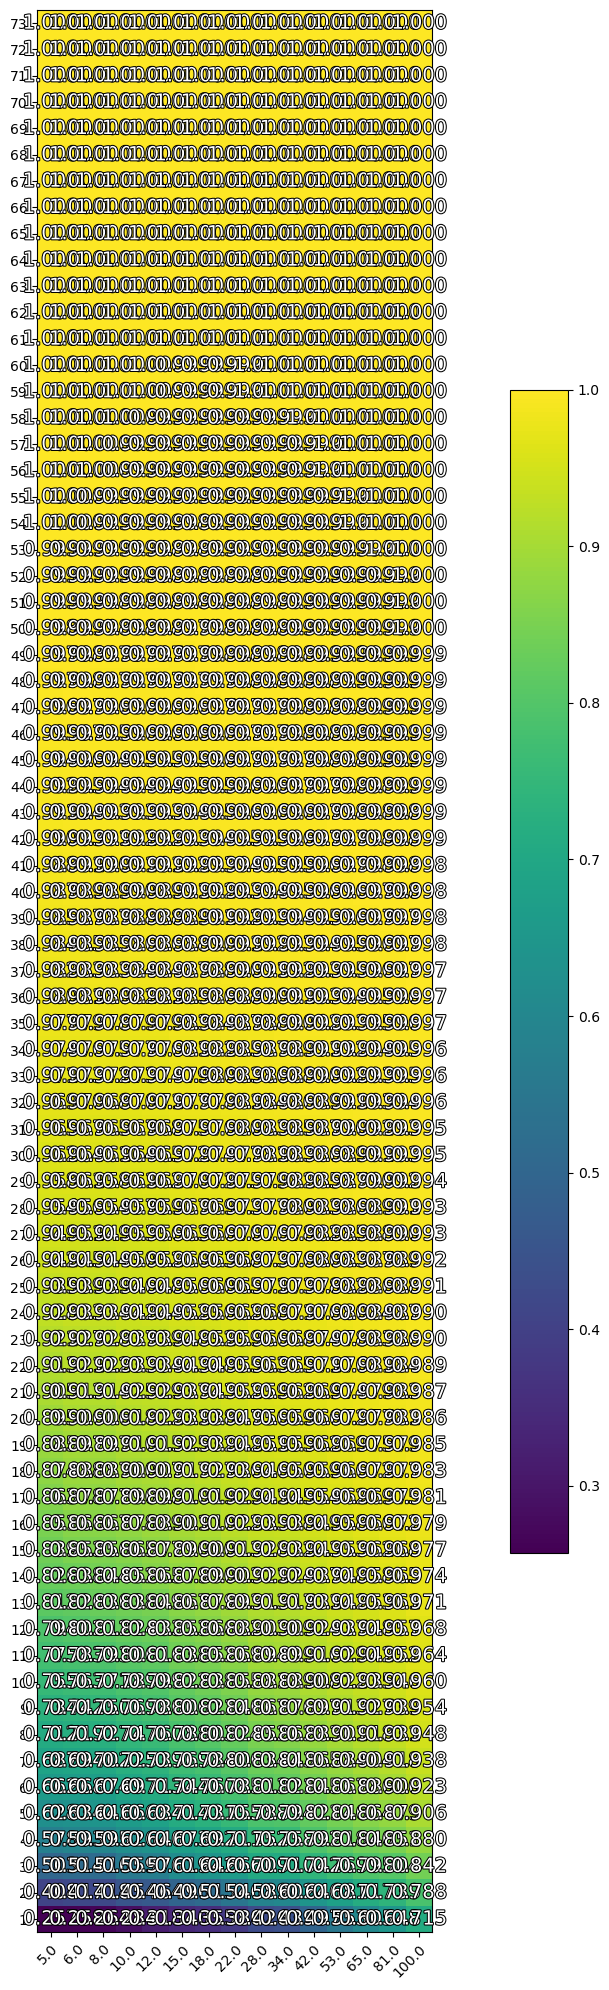

In [10]:
radius_pc_heatmap(expl_var_ratio_gauss)

In [11]:
print(expl_var_ratio_gauss[22.0])
print(expl_var_ratio_gauss[28.0])

[0.38028148 0.54575094 0.66605506 0.71094736 0.75484973 0.78491885
 0.80575607 0.82409946 0.8400029  0.85543422 0.86889687 0.8815409
 0.89315119 0.90328558 0.91309996 0.92169464 0.92934513 0.93579633
 0.94169542 0.94688664 0.95172332 0.9554778  0.95892115 0.96197576
 0.96491308 0.96762308 0.97022561 0.97274602 0.97516823 0.97741874
 0.9796608  0.98149056 0.98326296 0.98498599 0.98663532 0.98816383
 0.9895818  0.99082045 0.9919502  0.99305728 0.99399336 0.99488275
 0.99553784 0.9961107  0.99659189 0.99695629 0.99726691 0.99753278
 0.99777828 0.99801435 0.9982265  0.99841719 0.99858918 0.99874174
 0.99888845 0.99903033 0.99915341 0.99927342 0.99938484 0.99949503
 0.99958491 0.99967324 0.99974614 0.99980633 0.99986035 0.99990637
 0.99995012 0.99997556 0.99999689 0.99999852 1.         1.
 1.        ]
[0.42622583 0.58927573 0.7090678  0.75209466 0.78836175 0.81301297
 0.83375471 0.85196805 0.86695765 0.88140311 0.89360865 0.90329829
 0.91278032 0.92062872 0.92794929 0.9348385  0.94105646 0.

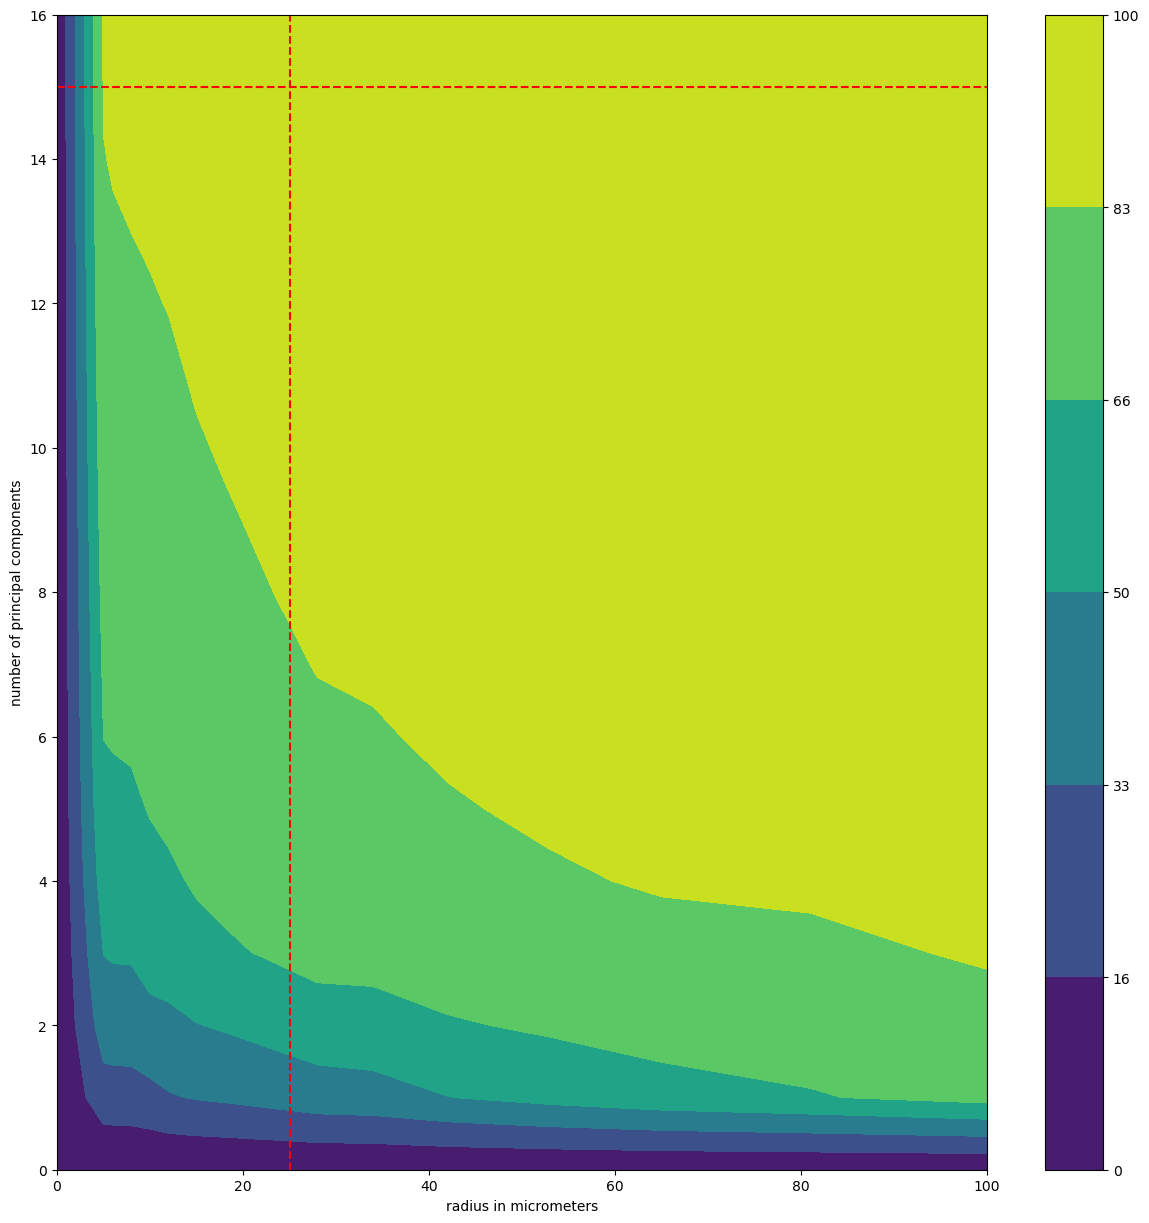

In [12]:
radius_pc_all_variance(expl_var_ratio_gauss,radius_lim=25,nPC_lim=15,cells_number=len(CELL_TYPES)+1, 
                       pca_limit=16,save_fig=True, path_fig="None")#"/scratch/ziqi.kang/HIFI_TMENs_analysis/plot_rad_var_gauss.svg")

## Sites cell abundance generation

In [9]:
N_SITE = 20000
RADIUS = 25
METHOD = "gaussian"

patient_id=[1]

CellAb_list = generate_abundance_matrix(CELL_TYPES, patient_id, N_SITE, RADIUS, method=METHOD,
                                        image_x_size=6500,image_y_size=6500,
                                        snr=3,center_sites_cells=False,root=ROOT_DATA_PATH)
sites, patients_ids, sites_ids, _ = join_abundance_matrices(CellAb_list)

CellAb_df = pd.DataFrame() 
for ca in CellAb_list:
    abundance_df = pd.DataFrame(ca.abundance_matrix,columns = CELL_TYPES)
    abundance_df['site_id'] = np.arange(len(abundance_df))
    abundance_df['patient_id'] = ca.patient_id
    CellAb_df = pd.concat([CellAb_df, abundance_df], axis=1)
CellAb_df = CellAb_df.reset_index()

#print(sites[0:10,:])
pca_obj = PCA()
pc_proj = pca_obj.fit_transform(sites)
pca_obj.explained_variance_ratio_
print(np.sum(pca_obj.explained_variance_ratio_[0:5]))


0.7693298176133682


In [10]:
print(pca_obj.explained_variance_[0])
print(sites.shape)
#print(sites[0:10,:])
print(ROOT_DATA_PATH)
print(CellAb_list[0].abundance_matrix)

2.4043394905494265e-07
(20000, 73)
../data/original_celltypes/
[[0.0002023  0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.00046759 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.00010946 0.         0.         ... 0.         0.         0.        ]]


0.7724387718087264
[0.40095308 0.16490987 0.1192959  0.04574093 0.04153899]


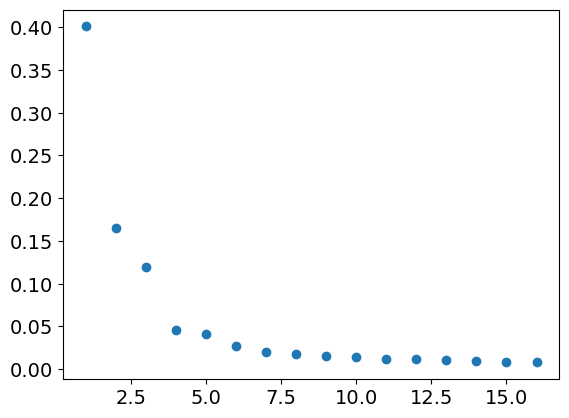

In [48]:
#print([*range(1,17)])
print(np.sum(pca_obj.explained_variance_ratio_[0:5]))
print(pca_obj.explained_variance_ratio_[0:5])
plt.scatter(x= [*range(1,17)],y = pca_obj.explained_variance_ratio_[0:16])

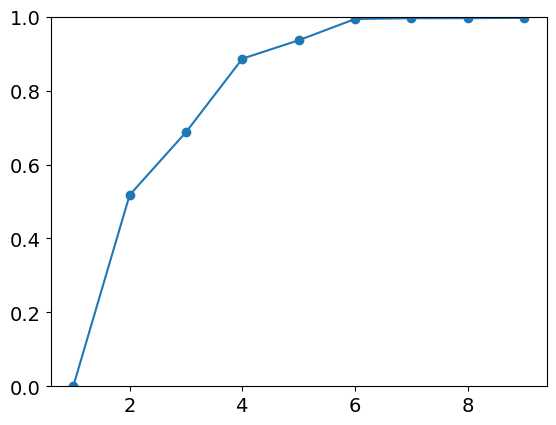

In [93]:
n_archs = list(range(1,10)) #list(range(3, 20))

lst_exp_var = []
for n_arch in n_archs:
    AA = ArchetypalAnalysis(n_archetypes = n_arch, 
                        tolerance = 0.001, 
                        max_iter = 200, 
                        random_state = 0, 
                        C = 0.0001, 
                        initialize = 'random',
                        redundancy_try = 30)
    AA.fit(pc_proj[:, :5])
    lst_exp_var.append(AA.explained_variance_)

plt.plot(n_archs, lst_exp_var, '-o')
plt.ylim(0, 1)
plt.show()

## Archetype analysis with 6 niches

In [14]:
NBNICHES = 6 #14#15

AA = ArchetypalAnalysis(n_archetypes = NBNICHES, 
tolerance = 0.001, 
max_iter = 500, 
random_state = 0, 
C = 0.0001, 
initialize = 'random', 
redundancy_try = 50)

AA.fit_transform(pc_proj[:,:NBNICHES-1])

array([[-3.35978062e-04, -2.66167970e-04,  5.07587224e-05,
         2.46640935e-05, -3.62231020e-05],
       [-5.46044367e-04,  1.50299279e-03,  9.09042840e-04,
        -1.94630261e-04, -1.30368847e-04],
       [-4.87458225e-04, -1.47402443e-04, -1.75235311e-04,
        -6.59911809e-05, -4.31468047e-05],
       ...,
       [ 3.75995303e-04,  4.34546738e-05, -9.76538817e-05,
        -2.82240723e-05, -1.18335180e-04],
       [-4.87930838e-04, -1.44367982e-04, -1.73749978e-04,
        -5.92792567e-05, -4.13042627e-05],
       [-2.67380324e-04, -8.34920446e-05, -2.27549337e-04,
        -6.16285475e-05, -5.84718543e-05]])

Reducing the dimension of sites cell abundance to 13 explains 80 % of  total variance
Archetype Analysis finds 14 niches which we will compare with our previous results.
Are there similarities between the 14 niches and the 5 niches found with only 32 cell types? Does the depth of clustering impact niche-phenotype mapping ? What is the optimal clustering depth of cell types to identify the niches ?

In [45]:
#print(AA.archetypes.T)
niches_cells=np.dot(AA.archetypes.T,pca_obj.components_[:NBNICHES-1,:])+np.mean(sites,axis=0)
niches_df = pd.DataFrame(niches_cells,columns=CELL_TYPES)
#print(niches_df.head())
'''
np.mean(niches_cells,axis=0)
mask = (np.mean(niches_cells,axis=0) > 0.00001)
idx = np.any(mask,axis=0)#mask.any(axis=0)
print(idx)
print(mask)
print(niches_cells[:,~idx])
niches_reduced_cells = niches_cells[:,mask]
niches_reduced_cells.shape
'''
#np.delete(niches_cells,np.where(np.mean(niches_cells,axis=0) >=0.00001)).shape

# Select cell types that make up at least 5% of niche in at least one niche
freqs_niches = niches_df.apply(lambda x: x.div(x.sum()).mul(100), axis=1).astype(int)
#print(freqs_niches.apply(lambda x: x.sum(),axis=0)>=5)
print(niches_df.loc[:,freqs_niches.apply(lambda x: x.sum(),axis=0)>=5].head())

niches_df_filt = niches_df.loc[:,freqs_niches.apply(lambda x: x.sum(),axis=0)>=5]

#meanCellT = niches_df.apply(np.mean,axis=0)
#print(meanCellT[meanCellT>0.00001])
#niches_df_filt = niches_df.loc[:,niches_df.apply(np.mean,axis=0)>0.00001]
#print(niches_df_filt.head())
#print(meanCellT[meanCellT>0.00001].index == niches_df_filt.columns)


   Proximal secretory  SFTPChigh distal  CTGFhigh distal epithelial  \
0            0.000030          0.000006                3.397235e-06   
1           -0.000121          0.002198                3.864901e-04   
2            0.000049          0.000017                9.116584e-07   
3           -0.000090          0.000026               -8.908924e-06   
4            0.000716          0.000018                8.168650e-05   

   Lymphatic endothelial  Immature arterial 2  Proliferating mes. 2  \
0              -0.000006             0.000227              0.002730   
1              -0.000009            -0.000018              0.000047   
2               0.000013             0.000005             -0.000002   
3              -0.000002             0.001499              0.000480   
4              -0.000008            -0.000080              0.000034   

       Arterial  Proliferating mes. 3  Ciliated epithelial  \
0 -4.328459e-05              0.000178            -0.000016   
1  6.627514e-07       

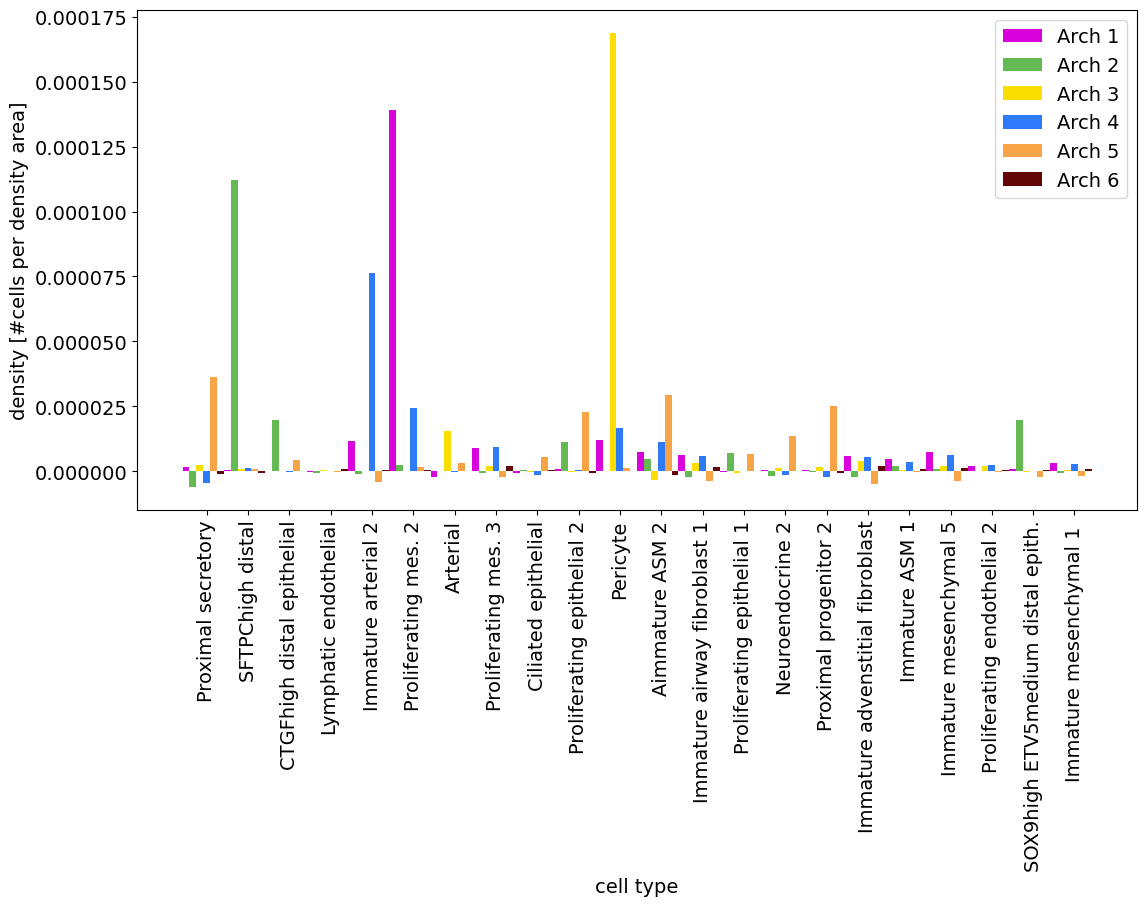

In [46]:
colors = ["#c752e5","#b90609","#b84ce2","#867d47","#c40232","#0ec3a4","#8a3ed0","#36f532","#6a8d36","#5fe12d",
"#acb07b","#04018c","#e5ed76","#a5ab4f","#b52200","#16cdc5","#bdc0ef","#676571","#0077d1","#1b8b43",
"#2bd7bf","#f76ad5","#3c9dfc","#ad16cc","#b098e2","#4865e3","#f6f941","#dec311","#dae122","#64f4f7",
"#fcaef7","#f5df03","#288039","#a02c31","#f40d30","#036f36","#64c769","#0f0673","#98a8a9","#7f4dae",
"#7a02c6","#ec3705","#6042ea","#1f12fe","#c50c67","#aa84ba","#b64d1c","#131e66","#946be7","#b005d3",
"#6cc08d","#10321e","#18e0ef","#1b06c4","#89f725","#8a97ab","#4da148","#fb6b8f","#e7dc02","#9462e7",
"#65d1dc","#9efee6","#d5a383","#19ca2c","#e9e72a","#17cbf2","#beef77","#ad8e58","#158ad3","#564de2",
"#e075c1","#301d2d","#57134c"]
colors=["#eba3a3","#ac67be","#64b952","#fbde01","#2e7af8","#43b090","#f7a447",
 "#d07935","#904365","#334144","#47ca9d","#d803dc","#038ea3", "#620608"]#"#fe99b3"]
colors=["#d803dc","#64b952","#fbde01","#2e7af8","#f7a447","#620608"]




archetypes_bar_plot(niches_df_filt.to_numpy(), niches_df_filt.columns, colors, y_axis='density', radius=RADIUS, path_fig=None)

* Niche 1: Proliferating mesenchymal 2, Immature arterial 2, Proliferating mesenchymal 3,  Immature advenstitial fibroblast, Pericyte and Immature ASM2, immature fibroblast 1, Immature mesenchymal 5 ==> mesenchymal tissue
* Niche 2: SFTPChigh distal, CTGFhigh distal epithelial, SOX9ETV5 medium distal epithelial ==> epithelium  
* Niche 3: Pericyte, arterial ==> arterial niche
* Niche 4: Immature arterial, proliferating mesenchymal 2, proliferating mesenchymal 3, pericyte, Aimmature ASM 2 ==>
* Niche 5: Proximal secretory, AImmature ASM2, Proximal progenitor 2, Proliferating eptihelial 2, Neuroendocrine 2 ==> 
* Niche 6: Empty niches ?


## Segmentation of image into niches

In [27]:
color_range = [[216, 3, 220],
 [100, 185, 82],
 [251, 222, 1],
 [46, 122, 248],
 [247, 164, 71],
 [98, 6, 8],
 [0, 0, 0]]

#100, 185, 82

 
color_list = color_range[0:NBNICHES]
print(color_list)

[[216, 3, 220], [100, 185, 82], [251, 222, 1], [46, 122, 248], [247, 164, 71], [98, 6, 8]]


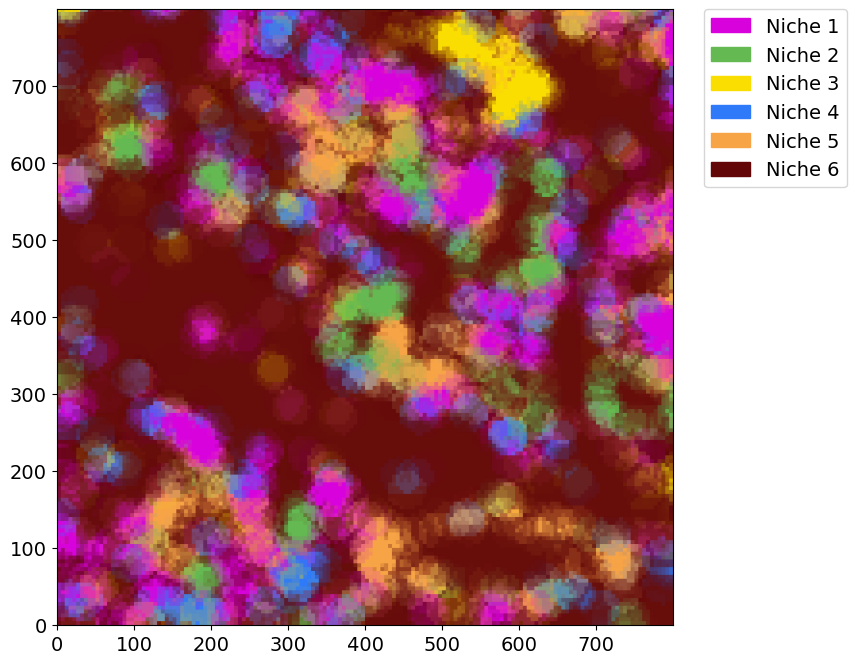

In [28]:
cell_data = pd.read_csv("{}/patient{}_cell_positions.csv".format(ROOT_DATA_PATH, 1))
h = 800
w = 800
GRANULARITY = 5 

plot_cells_positions(patch, CELL_TYPES, segment_image=True, counting_type='gaussian',
                            segmentation_type='smooth', color_vector = color_list,
                            h=h, w=w, granularity=GRANULARITY, radius=RADIUS,
                            pca_obj=pca_obj, AA_obj=AA, to_plot = 'None', path_fig=None)

## Archetype analysis with 5 niches 

In [11]:
NB_NICHES = 5#6 #14#15

AA_new = ArchetypalAnalysis(n_archetypes = NB_NICHES, 
tolerance = 0.001, 
max_iter = 500, 
random_state = 0, 
C = 0.0001, 
initialize = 'random', 
redundancy_try = 50)

AA_new.fit_transform(pc_proj[:,:NB_NICHES-1])

array([[ 1.05518540e-04, -3.16140761e-06, -2.49883268e-04,
        -2.80551654e-05],
       [-4.47483724e-04,  1.42864641e-04, -1.50866347e-04,
        -4.26322818e-05],
       [ 3.96959830e-05, -4.23267065e-04, -1.12366370e-05,
         2.24723086e-05],
       ...,
       [ 2.63441589e-05,  1.22003488e-05, -2.60063880e-04,
        -4.21867145e-05],
       [ 6.55944712e-04, -1.03537944e-05, -1.04505522e-04,
         6.36027114e-05],
       [-2.62868495e-04,  2.67432842e-04,  4.98913089e-05,
        -5.97164581e-05]])

In [12]:
#print(AA_new.archetypes.T)

## Compute niches cell type abundance
niches_cells=np.dot(AA_new.archetypes.T,pca_obj.components_[:NB_NICHES-1,:])+np.mean(sites,axis=0)
niches_df = pd.DataFrame(niches_cells,columns=CELL_TYPES)
#print(niches_df.apply(lambda x: x.div(x.sum()).mul(100), axis=1).astype(int))

# Select cell types that make up at least 5% of niche in at least one niche
freqs_niches = niches_df.apply(lambda x: x.div(x.sum()).mul(100), axis=1).astype(int)
#print(freqs_niches.apply(lambda x: x.sum(),axis=0)>=5)
print(niches_df.loc[:,freqs_niches.apply(lambda x: x.sum(),axis=0)>=5].head())

niches_df_filt = niches_df.loc[:,freqs_niches.apply(lambda x: x.sum(),axis=0)>=5]
#meanCellT = niches_df.apply(np.mean,axis=0)
#print(meanCellT[meanCellT>0.00001])
#niches_df_filt = niches_df.loc[:,niches_df.apply(np.mean,axis=0)>0.00001]
#print(niches_df_filt.head())
#print(meanCellT[meanCellT>0.00001].index == niches_df_filt.columns)



   Proximal secretory  SFTPChigh distal  CTGFhigh distal epithelial  \
0           -0.000009          0.000013               -6.730808e-06   
1           -0.000062          0.001990                3.564195e-04   
2           -0.000026          0.000017               -3.122018e-06   
3            0.000453         -0.000023                5.135265e-05   
4           -0.000071         -0.000009                6.805658e-07   

   Immature arterial 2  Proliferating mes. 2  Arterial  Proliferating mes. 3  \
0             0.000548              0.003101 -0.000036              0.000219   
1             0.000149              0.000018  0.000005              0.000003   
2             0.000625              0.000154  0.000172              0.000108   
3            -0.000395              0.000056  0.000040             -0.000029   
4             0.000163              0.000028  0.000003              0.000058   

   Ciliated epithelial  Proliferating epithelial 2  Pericyte  ...  \
0        -2.983370e-05 

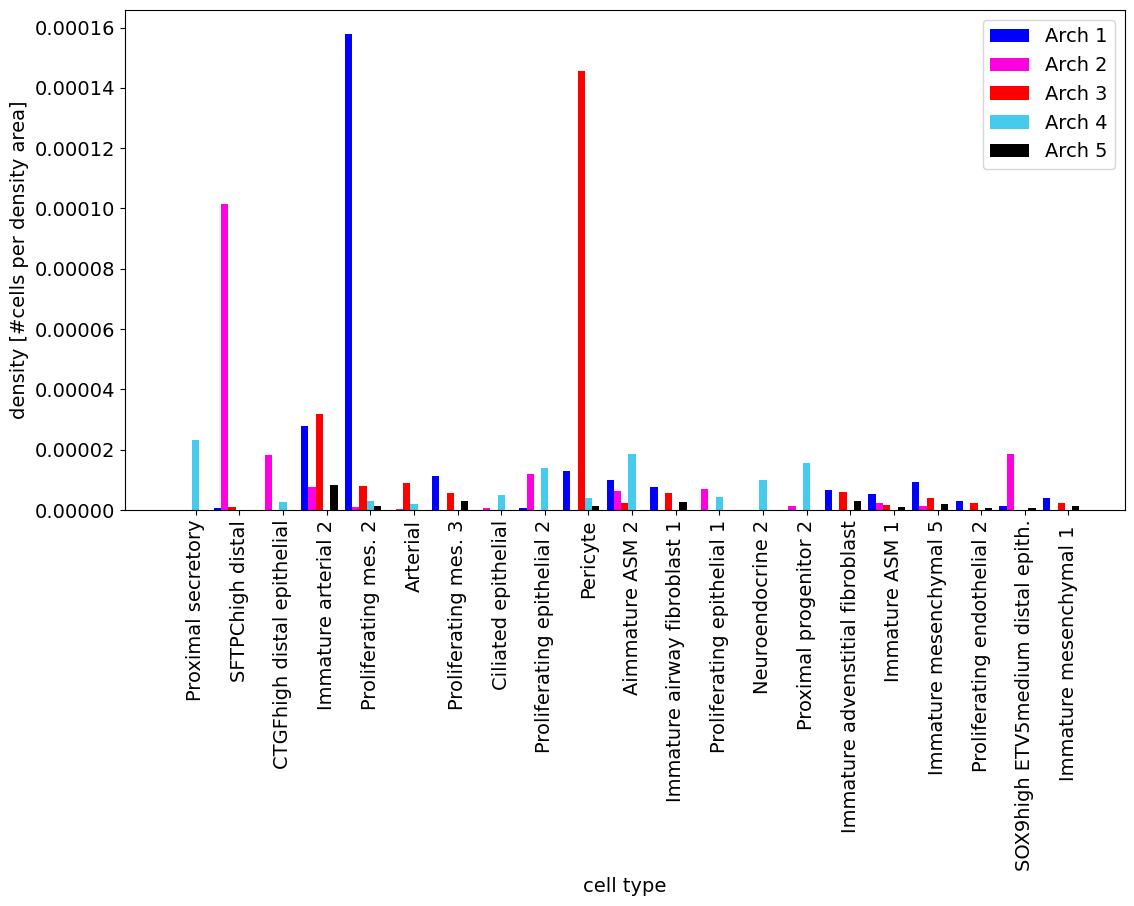

In [13]:
colors=["#64b952","#fbde01","#2e7af8","#f7a447","#620608"]
#FIXME use Ziqi's range of colors
#TODO save barplot
color_range = [[255, 0, 223],
 [0, 0, 255],
 [70, 203, 236],
 [255, 0, 0],
 [0, 0, 0],
 [0, 153, 51], 
 [225, 255, 0]] 

color_range = [[0, 0, 255],
 [255, 0, 223],
 [255, 0, 0],
 [70, 203, 236],             
 [0, 0, 0]]
colors = np.array(color_range[0:NB_NICHES])/255

nichesCA = niches_df_filt.to_numpy()
nichesCA[nichesCA<0] = 0

archetypes_bar_plot(nichesCA, niches_df_filt.columns, colors, y_axis='density', radius=RADIUS, path_fig='../output/barplot_originalCT.svg')

[[100, 185, 82], [251, 222, 1], [46, 122, 248], [247, 164, 71], [98, 6, 8]]


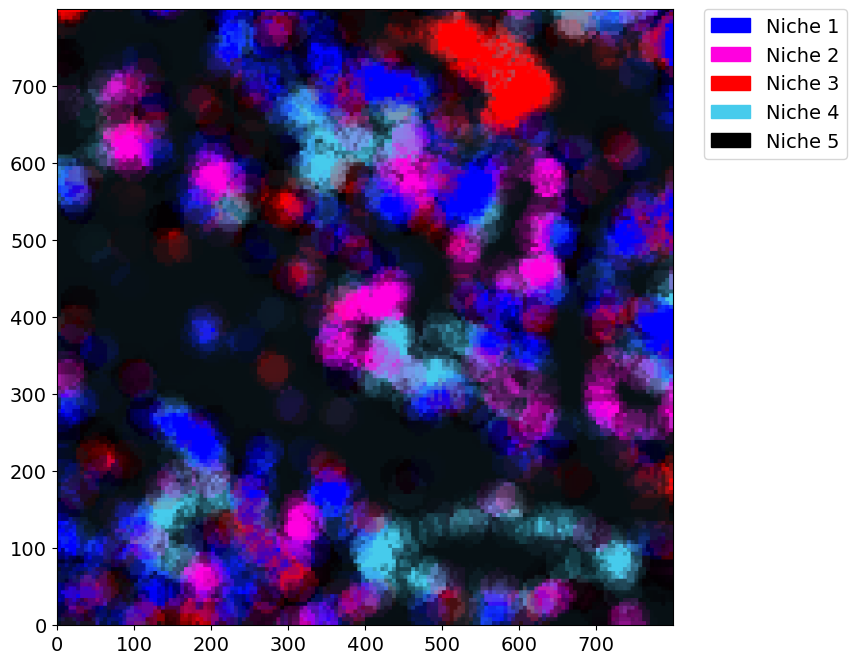

In [16]:
color_range = [[100, 185, 82],
 [251, 222, 1],
 [46, 122, 248],
 [247, 164, 71],
 [98, 6, 8],
 [0, 0, 0]]
#FIXME use Ziqi's color code 
#Save .svg 
color_list = color_range[0:NB_NICHES]
print(color_list)

color_range = [[0, 0, 255],
 [255, 0, 223],
 [255, 0, 0],
 [70, 203, 236],             
 [0, 0, 0]]
color_list = color_range[0:NB_NICHES]

h = 800
w = 800
GRANULARITY = 5 
plot_cells_positions(patch, CELL_TYPES, segment_image=True, counting_type='gaussian',
                            segmentation_type='smooth', color_vector = color_list,
                            h=h, w=w, granularity=GRANULARITY, radius=RADIUS,
                            pca_obj=pca_obj, AA_obj=AA_new, to_plot = 'None', path_fig='../output/niches_seg_originalCT.svg')